In [3]:
import pandas as pd
import delicardservice as ds
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
cardNr = "123456"
password = "abcd"
ds.scrapeDelicardApi(cardNr,password)
ds.mergeDataDumps(cardNr)
data: pd.DataFrame = ds.getDataframe(cardNr)

# overview of the data
data

datum    ortName        kaName  typName   
transFullId posId                                                         
10-3419-37  1     2022-12-08 11:36:00  Cafeteria  Cafeteria 10  Verkauf  \
            2     2022-12-08 11:36:00  Cafeteria  Cafeteria 10  Verkauf   
            3     2022-12-08 11:36:00  Cafeteria  Cafeteria 10  Verkauf   
7-4003-599  1     2022-12-08 12:58:00      Mensa  Mensakasse 7  Verkauf   
            2     2022-12-08 12:58:00      Mensa  Mensakasse 7  Verkauf   
...                               ...        ...           ...      ...   
10-3581-403 1     2023-04-19 10:54:00  Cafeteria  Cafeteria 10  Verkauf   
7-4084-644  1     2023-04-19 13:49:00      Mensa  Mensakasse 7  Verkauf   
            2     2023-04-19 13:49:00      Mensa  Mensakasse 7  Verkauf   
            3     2023-04-19 13:49:00      Mensa  Mensakasse 7  Verkauf   
            4     2023-04-19 13:49:00      Mensa  Mensakasse 7  Verkauf   

                   zahlBetrag                  name  menge  epreis  gpreis   
transFullId posId                                                            
10-3419-37  1           -3.50    Kaffee, Pfandtasse      1    1.20    1.20  \
            2           -3.50      Tassenpfand plus      1    1.00    1.00   
            3           -3.50   Brötchen mit Salami      1    1.30    1.30   
7-4003-599  1           -4.40     Stamm HK Essen 10      2    2.20    4.40   
            2           -4.40  Tafelwasser 0,3l Gl.      1    0.30    0.00   
...                       ...                   ...    ...     ...     ...   
10-3581-403 1           -1.30     Brötchen mit Pute      1    1.30    1.30   
7-4084-644  1           -6.25     Counter Dessert 1      1    1.50    1.50   
            2           -6.25      Schälchen Pommes      1    1.10    1.10   
            3           -6.25               Ketchup      1    0.15    0.15   
            4           -6.25   Aktionsessen 3,50 €      1    3.50    3.50   

                   rabatt  
transFullId posId          
10-3419-37  1         NaN  
            2         NaN  
            3         NaN  
7-4003-599  1         NaN  
            2         0.3  
...                   ...  
10-3581-403 1         NaN  
7-4084-644  1         NaN  
            2         NaN  
            3         NaN  
            4         NaN  

[302 rows x 10 columns]

### Inflation check

In [4]:
# remove balance top-ups (~ is a `not` operator)
spendings = data[~data["name"].isin(["Karte aufwerten","Aufwertung"])]

priceIncreasings = data[~data["name"].str.contains("Karte aufwerten|Aufwertung|Antipastibuffet")]
priceIncreasings = priceIncreasings.groupby("name").agg(increase=("epreis", lambda x: x.max() - x.min()), min=("epreis", "min"), max=("epreis", "max")).sort_values(by=("increase"), ascending=False)
priceIncreasings = priceIncreasings[priceIncreasings["increase"] != 0]
if priceIncreasings.empty:
    print("Prices did not increase")
priceIncreasings

Prices did not increase


,increase,min,max
name,,,


In [5]:
# Top 5 most expensive products
spendings.sort_values(by="epreis", ascending=False).head(5)

,,datum,ortName,kaName,typName,zahlBetrag,name,menge,epreis,gpreis,rabatt
transFullId,posId,,,,,,,,,,
7-4075-546,1,2023-04-05 13:30:00,Mensa,Mensakasse 7,Verkauf,-8.2,"Aktionsessen 6,35 €",1,6.35,6.35,NaN
5-2698-467,2,2023-02-10 13:02:00,Mensa,Mensakasse 5,Verkauf,-6.7,"Aktionsessen 5,90 €",1,5.90,5.90,NaN
2-3265-253,2,2023-01-18 12:50:00,Mensa,Mensakasse 2,Verkauf,-6.6,"Aktionsessen 5,80 €",1,5.80,5.80,NaN
24-357-239,3,2023-01-17 12:40:00,Mensa,Mobile Kasse,Verkauf,-6.6,"Aktionsessen 5,80 €",1,5.80,5.80,NaN
4-941-384,2,2023-01-10 12:35:00,Mensa,Mensakasse 4,Verkauf,-6.4,"Aktionsessen 5,60 €",1,5.60,5.60,NaN


In [6]:
# top 10 frequently ordered products
topDishes = data[~data["name"].str.contains("Karte aufwerten|Aufwertung|Tafelwasser|Tassenpfand")]
topDishes["name"].value_counts().head(10).to_frame()

,count
name,
"Kaffee, Pfandtasse",21
Stamm Dessert,18
Stamm HK Essen 13,12
Counter Dessert 1,12
Antipastibuffet Mittelteller,11
Stamm Gemüsebeilage 1,9
Stamm Sättigungsbeilage 1,7
Antipastibuffet kl. Schälchen,6
"Aktionsessen 3,80 €",6


In [7]:
# Prices for Stamm Essen
data.loc[data["name"].str.contains("Stamm") & ~data["name"].str.contains("STORNO")].groupby("name")["epreis"].last().to_frame().sort_values(by="name")

,epreis
name,
Stamm Beilagensalat,0.8
Stamm Dessert,0.8
Stamm Gemüsebeilage 1,0.8
Stamm Gemüsebeilage 2,0.8
Stamm HK Essen 10,2.2
Stamm HK Essen 13,2.8
Stamm HK Essen 14,2.8
Stamm HK Essen 15,2.8
Stamm HK Essen 2,1.7


### Facts and figures

In [8]:
print(f"Verfügbarer Datenzeitraum: {data['datum'].min().date().strftime('%d.%m.%Y')} bis {data['datum'].max().date().strftime('%d.%m.%Y')}")

Verfügbarer Datenzeitraum: 08.12.2022 bis 19.04.2023


In [9]:
def convertEuro(float):
    '''Converts a number in € format.'''
    return "{:,.2f}€".format(float)

# total spendings
totalCosts = convertEuro(spendings["gpreis"].sum())
print(f"Insgesamt wurden {totalCosts} ausgegeben!")

# Show coffee and tea spendings
beveragesCosts = convertEuro(data[data["name"].str.contains("Kaffee|Tee")]["gpreis"].sum())
print(f"    - {beveragesCosts} für heiße Getränkte")

# Spendings for desserts
dessertsCosts = convertEuro(data[data["name"].str.contains("Dessert")]["gpreis"].sum())
print(f"    - {dessertsCosts} für Desserts")
joghurt = convertEuro(data[data["name"].str.contains("Stamm Dessert")]["gpreis"].sum())
print(f"       * {joghurt} für Joghurt")
sonstigeDesserts = convertEuro(data[data["name"].str.contains("Counter Dessert")]["gpreis"].sum())
print(f"       * {sonstigeDesserts} für sonstige Desserts")

# Not returned mugs
mugsPlus = data[data["name"].str.contains("Tassenpfand plus")].menge.sum()
mugsMinus = data[data["name"].str.contains("Tassenpfand minus")].menge.sum()
print("Nicht zurückgegebene Tassen:", mugsPlus - mugsMinus)


# Show spendings by facility
print("\nAusgaben nach Ort:")
mensa = spendings[["ortName", "menge", "gpreis", "rabatt"]].groupby("ortName").sum()
mensa

Insgesamt wurden 355.25€ ausgegeben!
    - 28.80€ für heiße Getränkte
    - 33.10€ für Desserts
       * 13.60€ für Joghurt
       * 19.50€ für sonstige Desserts
Nicht zurückgegebene Tassen: 1

Ausgaben nach Ort:


,menge,gpreis,rabatt
ortName,,,
Bona Vista,5,-5.00,0.00
Cafeteria,103,79.35,0.00
Mensa,167,268.70,11.12
Mensa Forum,10,12.20,0.80


### Graphs

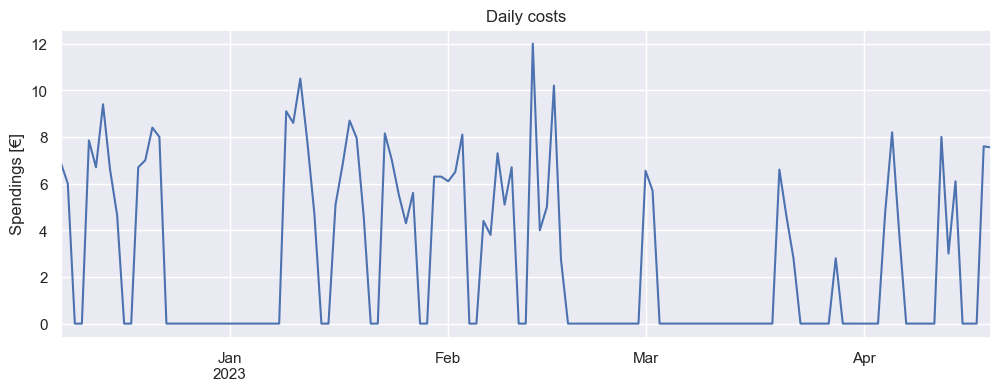

In [10]:
import matplotlib.dates as mdates
# Show graphs about total spendings per day/week
# spendings per day
dailycosts = spendings.resample("D", on="datum")["gpreis"].sum()
ax = dailycosts.plot(kind="line", figsize=(12,4), title="Daily costs", xlabel="", ylabel="Spendings [€]")

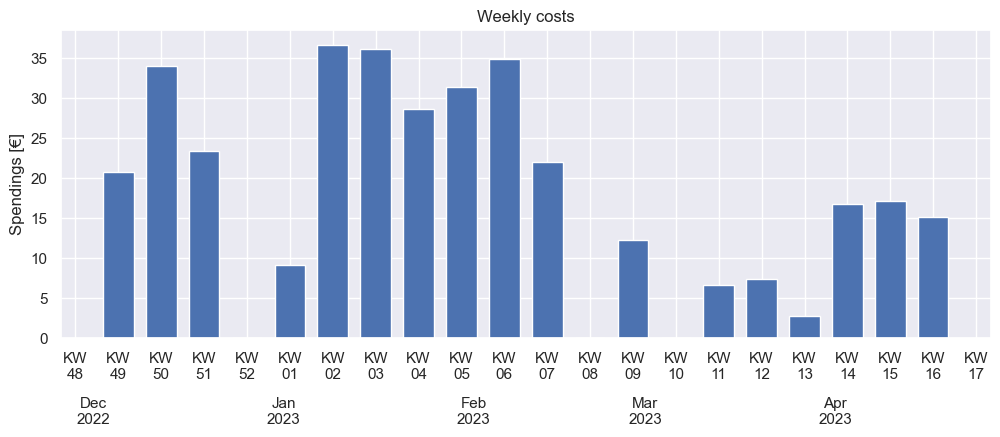

In [11]:
weeklycosts = dailycosts.resample("W-MON", label="left").sum()
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(weeklycosts.index, weeklycosts.values, width=100/len(weeklycosts.index))
ax.set(title="Weekly costs", ylabel="Spendings [€]")
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("KW\n%W"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("\n\n\n%b\n%Y"))